# Imports

In [1]:
import pyxdf
import pandas as pd
import numpy as np
import sounddevice as sd
from glob import glob
from tqdm import tqdm
import librosa
import datetime
import matplotlib.pyplot as plt


# Load Data

In [2]:
sub_files = glob('../../../*/*.xdf')
sub_files

['../sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [3]:
xdf_path = sub_files[4]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
# get rows of df in between time stamps corresponding to event_onset and event_offset
# get df data within event 
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['Tobii',
 'Stimuli_Markers',
 'WebcamStream',
 'OpenSignals',
 'EGI NetAmp 0',
 'Microphone']

# Stimulus

In [4]:
stim_dat = data[streams_collected.index('Stimuli_Markers')]
stim_df = pd.DataFrame(stim_dat['time_series'])
stim_df.rename(columns={0: 'trigger'}, inplace=True)
events = {
    200: 'Onset_Experiment',
    10: 'Onset_RestingState',
    11: 'Offset_RestingState',
    500: 'Onset_StoryListening',
    501: 'Offset_StoryListening',
    100: 'Onset_10second_rest',
    101: 'Offset_10second_rest', 
    20: 'Onset_CampFriend',
    21: 'Offset_CampFriend',
    30: 'Onset_FrogDissection',
    31: 'Offset_FrogDissection',
    40: 'Onset_DanceContest',
    41: 'Offset_DanceContest',
    50: 'Onset_ZoomClass',
    51: 'Offset_ZoomClass',
    60: 'Onset_Tornado',
    61: 'Offset_Tornado',
    70: 'Onset_BirthdayParty',
    71: 'Offset_BirthdayParty',
    300: 'Onset_subjectInput',
    301: 'Offset_subjectInput',
    302: 'Onset_FavoriteStory',
    303: 'Offset_FavoriteStory',
    304: 'Onset_WorstStory',
    305: 'Offset_WorstStory',
    400: 'Onset_impedanceCheck',
    401: 'Offset_impedanceCheck',
    80: 'Onset_SocialTask',
    81: 'Offset_SocialTask',
    201: 'Offset_Experiment',
}

story_onsets = [20, 30, 40, 50, 60, 70]

# relabel the event if the trigger is in the events dictionary, else if 
stim_df['event'] = stim_df['trigger'].apply(lambda x: events[x] if x in events.keys() else 'Bx_input')

# relabel the event as a psychopy timestamp if the trigger is greater than 5 digits
stim_df.loc[stim_df.trigger.astype(str).str.len() > 5, 'event'] = 'psychopy_time_stamp'
stim_df['lsl_time_stamp'] = stim_dat['time_stamps']
stim_df['time'] = (stim_dat['time_stamps'] - stim_dat['time_stamps'][0])/1000
stim_df

,trigger,event,lsl_time_stamp,time
0,2.000000e+02,Onset_Experiment,22180.430765,0.000000e+00
1,1.736874e+09,psychopy_time_stamp,22180.430776,1.159986e-08
2,1.000000e+01,Onset_RestingState,22249.074837,6.864407e-02
3,1.736874e+09,psychopy_time_stamp,22249.074850,6.864409e-02
4,1.100000e+01,Offset_RestingState,22549.074042,3.686433e-01
...,...,...,...,...
256,1.736877e+09,psychopy_time_stamp,24556.596770,2.376166e+00
257,2.010000e+02,Offset_Experiment,24561.589122,2.381158e+00
258,1.736877e+09,psychopy_time_stamp,24561.589140,2.381158e+00
259,4.000000e+00,Bx_input,24561.589315,2.381159e+00


# Microphone Data 

In [5]:
mic_data = data[streams_collected.index('Microphone')]
mic_df = pd.DataFrame(mic_data['time_series'], columns=['int_array'])
mic_df['bytestring'] = mic_df['int_array'].apply(lambda x: np.array(x).tobytes())
mic_df['time_stamps'] = (mic_data['time_stamps'] - mic_data['time_stamps'][0])/441000

mic_df['lsl_time_stamp'] = mic_data['time_stamps']
mic_df['time'] = (mic_df.lsl_time_stamp - mic_df.lsl_time_stamp[0])
mic_df['time_delta'] = mic_df['lsl_time_stamp'].diff()

mic_df.tail()

,int_array,bytestring,time_stamps,lsl_time_stamp,time,time_delta
87190106,20,b'\x14\x00\x00\x00\x00\x00\x00\x00',0.004483,24606.576369,1977.204618,0.000023
87190107,20,b'\x14\x00\x00\x00\x00\x00\x00\x00',0.004483,24606.576391,1977.204641,0.000023
87190108,20,b'\x14\x00\x00\x00\x00\x00\x00\x00',0.004483,24606.576414,1977.204664,0.000023
87190109,22,b'\x16\x00\x00\x00\x00\x00\x00\x00',0.004483,24606.576437,1977.204686,0.000023
87190110,3,b'\x03\x00\x00\x00\x00\x00\x00\x00',0.004483,24606.576459,1977.204709,0.000023


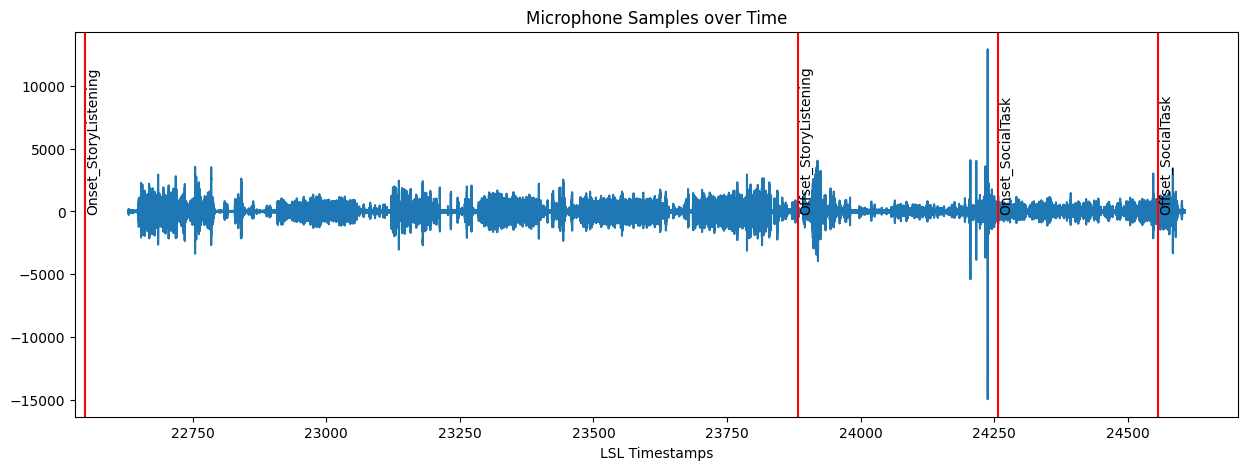

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(mic_df.lsl_time_stamp, mic_df.int_array)
for event in stim_df.loc[stim_df.event.str.contains('StoryListening|SocialTask')].iterrows():
    plt.axvline(event[1]['lsl_time_stamp'], color='r')
    plt.text(event[1]['lsl_time_stamp']+2, 0, event[1]['event'], rotation=90)

plt.xlabel('LSL Timestamps')
plt.title('Microphone Samples over Time')
plt.show()